# Assignment 2: Implementing Decoding Strategies for Summarization (40 points)

In this assignment, you will **implement decoding algorithms** used for text summarization using a pretrained Transformer model.

---

### Your Task
1. **Load** the `sshleifer/distilbart-cnn-12-6` summarization model.
2. **Implement the following decoding strategies from scratch** (no `.generate()` allowed!). You need to provide your own explanation on your implementation for each function:
   - Greedy decoding (3 points)
   - Top-k sampling (3 points)
   - Top-p (nucleus) sampling (3 points)
   - Beam search (3 points)
   - Beam search with n-gram blocking (3 points)
3. Use your decoder to summarize 200 articles from the CNN/DailyMail dataset.
4. Implement the following ROUGE metrics and evaluate your summaries using your own ROUGE metric implementation.
  - Implementation
    - ROUGE-n (2 points): e.g., ROUGE-1 & ROUGE-2
    - ROUGE-L (4 points)
  - Explanation on your implementation (2 points)
  - Discuss how to improve these metrics to perform a better evaluation? (2 points)
5. Discussion (15 points)

---

**Note:**
  - Regarding the decoding strategies, you are expected to work directly with model logits and sampling logic. Do not use `model.generate()` or any pre-built function. **Hint**: use "outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)"
  - For each function, you need to write clear and concise comments about your implementation. This may not be line-by-line, but rather meaningful chunk of codes.
  - For each question, justify your answer with explanations.

### **We highly recommend using 'cpu' as the default for development, and switching to 'gpu' only for evaluating summarization performance. This is due to the limited GPU availability in the Colab environment.**


In [1]:
!pip install transformers datasets --quiet


In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import torch
import json
import torch.nn.functional as F
import random
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load model and tokenizer
model_name = "sshleifer/distilbart-cnn-12-6"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
# load model to gpu for faster inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")
model.eval()


/data2/cmdir/home/giangnl/.conda/envs/deepseek_ft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In this assignment, we use the CNN/DailyMail summarization dataset, a widely-used benchmark for training and evaluating text summarization models.

Each data sample consists of:

- article: A news story, usually between 300 and 800 words.

- highlights: A bullet-style abstractive summary of the article, written by human editors.

This dataset is ideal for testing decoding strategies because:

- The summaries are relatively short and factual

- The dataset is large enough to support diverse decoding behavior

- It has been used in many summarization papers, making ROUGE scores easy to compare

In this assignment, we will use a small subset of 200 samples from the validation set for quick experimentation and evaluation.

In [3]:
# Upload cnn_dm_200.json file

# Load 200-sample dataset
with open("cnn_dm_200.json", "r") as f:
    dataset = json.load(f)

print("Because the limited computation resource in google collab, I only use first 10 samples from the dataset to run experiment.")
dataset = dataset[:10]

print(f"Loaded {len(dataset)} samples.")
print("\nExample article:")
print(dataset[0]["article"])
print("\nReference summary:")
print(dataset[0]["highlights"])


Because the limited computation resource in google collab, I only use first 10 samples from the dataset to run experiment.
Loaded 10 samples.

Example article:
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of 

## Decoding in Language Models
Pretrained language models like BART or GPT generate text by predicting the most likely next token one at a time.
However, simply choosing the most probable token at each step often leads to deterministic, repetitive, or generic outputs.

To overcome this, several decoding strategies have been proposed to balance:

- fluency vs. diversity

- coherence vs. novelty

In this assignment, you will implement five widely-used decoding strategies from scratch and compare their effects.

### Greedy Decoding

In [4]:
def greedy_decode(input_ids, max_length=30):
    """
    Perform greedy decoding from the model using logits.

    Args:
        input_ids (torch.Tensor): Tokenized input tensor of shape [1, seq_len].
        max_length (int): Maximum length of the generated sequence.

    Returns:
        str: Decoded summary text.
    """
    # TODO: Implement Greedy Decoding from scratch
    input_ids = input_ids.to(device) # load model to device
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device) # take the start token for decoding
    eos_token_id = model.config.eos_token_id # take the EOS token id from the vocab

    for _ in range(max_length):

        with torch.no_grad():
            output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
        proba_output = torch.softmax(output.logits[:,-1,:],axis=-1) # take the last token logits and apply softmax to get the probability of each token
        id = torch.tensor([[torch.argmax(proba_output, axis=-1)]]).to(device) # greedy approach to take the token_id with largest probability
        decoder_input_ids = torch.cat([decoder_input_ids,id],axis=-1) # append the decoded token to the generated token sequence

        if id.item() == eos_token_id: # If the model generate an EOS token, the decoding process should be stop
            break

    summary = tokenizer.decode(decoder_input_ids[0], skip_special_tokens=True) # convert the generated token sequence to string

    return summary


Explain your implementation

My implementation performs greedy decoding for a sequence-to-sequence model by iteratively generating tokens based on the highest probability prediction at each step. Firstly, it inputs a decoder start token id to start auto-regressive process. The model takes in decoder start token id and returns logits for next token. The softmax function is applied to convert logits to probabilites, and the token id, which is the index in the tensor, is chosen with respect to the highest probability. The chosen token id is then concatenated with the sequence of previously generated tokens, to feed back into the model for the next iteration. The process stop until model outputs the end of sentence token.


### Top-k Decoding

In [5]:
def top_k_decode(input_ids, k=5, max_length=30, temperature=1.0):
    """
    Perform Top-k sampling decoding from the model.

    Args:
        input_ids (torch.Tensor): Tokenized input tensor of shape [1, seq_len].
        k (int): Number of top tokens to sample from.
        max_length (int): Maximum length of the generated sequence.
        temperature (float): Softmax temperature for sampling.

    Returns:
        str: Decoded summary text.
    """
    # TODO: Implement Top-k Sampling Decoding
    input_ids = input_ids.to(device)
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device) # take the start token for decoding
    eos_token_id = model.config.eos_token_id # take the EOS token id from the vocab

    for _ in range(max_length):
      with torch.no_grad():
        output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
      output_proba = torch.softmax(output.logits[:,-1,:]/temperature,axis=-1) # convert logits to probability, devide by the temperature to control the randomness and shape of probability distribution
      values, indices = torch.topk(output_proba, k=k, axis=-1) # take top k tokens with largest probability
      values = values/ torch.sum(values,axis=-1,keepdim=True).item() # redistribute probability of selected tokens, made them summing up to 1
      local_index = torch.multinomial(values[0],num_samples=1) # sampling from redistributed probability distribution
      id = indices[:,local_index] # take the token id of the sampled token
      decoder_input_ids = torch.cat([decoder_input_ids,id],axis=-1) # add the sampled token to the generated token sequence

      if id.item() == eos_token_id: # If the model generate an EOS token, the decoding process should be stop
        break

    summary = tokenizer.decode(decoder_input_ids[0], skip_special_tokens=True) # convert the generated token sequence to string
    return summary




- Explain your implementation.
- What are the role of hyperparameters of this strategy? and what happen if you change the values?

- My implementation of top-k sampling involves selecting the top k most probable tokens from the model's output logits at each decoding step. The logits are first converted to probabilities using the softmax function. Then, use torch.topk function to select k indices with largest probabilities. Then, the probabilities of k selected tokens must be redistributed to have sum of 1. After that, I sample a token using torch.multinomial function to sample elements from a given probability distribution. This process is repeated until an end-of-sequence token is generated or a maximum length is reached.
- The hyperparameter k determines the number of top tokens to consider for sampling. A smaller k leads to more deterministic outputs, as fewer options are available, while a larger k increases diversity but may introduce noise. If k is set too high, the model may generate less coherent or relevant text, as it has too many options to choose from. Conversely, if k is too low, the generated text may become repetitive or lack variety. If k is set to 1, top k sampling becomes equivalent to greedy decoding, as only the most probable token is selected at each step.
- The hyperpatameter temperature is used to control the randomness of the sampling process. A lower temperature results in more conservative and deterministic outputs, while a higher temperature increases diversity but may lead to less coherent text. If the temperature is set to 1, it means no scaling is applied to the logits, and the sampling process behaves as if it were using the original probabilities. If we increase the temperature, the probabilities distribution becomes more uniform. In contrast, we reduce the temperature, the distribution becomes sharper.

### Top-p Decoding

In [6]:
def top_p_decode(input_ids, p=0.9, max_length=30, temperature=1.0):
    """
    Perform Top-p (nucleus) sampling decoding from the model.

    Args:
        input_ids (torch.Tensor): Tokenized input tensor of shape [1, seq_len].
        p (float): Cumulative probability threshold for sampling.
        max_length (int): Maximum length of the generated sequence.
        temperature (float): Softmax temperature for sampling.

    Returns:
        str: Decoded summary text.
    """
    # TODO: Implement Top-p Sampling Decoding

    input_ids = input_ids.to(device)
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device) # take the start token for decoding
    eos_token_id = model.config.eos_token_id # take the EOS token id from the vocab

    for _ in range(max_length):
      with torch.no_grad():
        output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
      output_proba = torch.softmax(output.logits[:,-1,:]/temperature,axis=-1)[0] # convert logits to probability, devide by the temperature to control the randomness and shape of probability distribution
      sorted_probs, sorted_indices = torch.sort(output_proba, descending=True) # sort the probabilites and their corresponding token ids
      cumulative_probs = torch.cumsum(sorted_probs, dim=0) # calculate the cumulative probability
      nucleus_mask = cumulative_probs <= p # create a mask for the tokens that are below the threshold
      nucleus_mask[max((cumulative_probs > p).nonzero(as_tuple=True)[0][0], 0)] = True # Ensure we include at least one token after passing threshold
      nucleus_probs = sorted_probs[nucleus_mask] # filter the probabilities based on the mask
      nucleus_indices = sorted_indices[nucleus_mask] # filter the token ids based on the mask
      nucleus_probs = nucleus_probs/torch.sum(nucleus_probs) # redistribute the probabilities of the selected tokens
      local_index = torch.multinomial(nucleus_probs,num_samples=1) # sampling from redistributed probability distribution
      id = torch.tensor([[nucleus_indices[local_index]]]).to(device)
      decoder_input_ids = torch.cat([decoder_input_ids,id],axis=-1)

      if id.item() == eos_token_id: # If the model generate an EOS token, the decoding process should be stop
        break


    summary = tokenizer.decode(decoder_input_ids[0], skip_special_tokens=True)
    return summary



- Explain your implementation.
- What are the role of hyperparameters of this strategy? and what happen if you change the values?

- My implementation of top-p (percentile) decoding is different from top-k sampling in that: It selects the smallest set of tokens whose cumulative probability exceeds a threshold p. The logits are first devided by temperature to control the shape of distribution and converted to probabilities using the softmax function. Then, I sort the probabilities in descending order and compute the cumulative sum. I select the smallest set of tokens such that their cumulative probability is greater than or equal to p, implemented by using masks for filtering in tensor. After that, the probabilities of selected candidates must be redistributed to sum up 1. Afterwards, I sample a token from this set and the remaining process is similar to the top-k sampling method. This process is repeated until an end-of-sequence token is generated or a maximum length is reached.      
- The hyperparameter p determines the threshold for cumulative probability. A smaller p leads to more deterministic outputs, as fewer options are available, while a larger p increases diversity but may introduce noise. If p is set too high, the model may generate less coherent or relevant text, as it has too many options to choose from. Conversely, if p is too low, the generated text may become repetitive or lack variety.
- The hyperpatameter temperature is used to control the randomness of the sampling process. A lower temperature results in more conservative and deterministic outputs, while a higher temperature increases diversity but may lead to less coherent text. If the temperature is set to 1, it means no scaling is applied to the logits, and the sampling process behaves as if it were using the original probabilities. If we increase the temperature, the probabilities distribution becomes more uniform. In contrast, we reduce the temperature, the distribution becomes sharper.


### Beam Search Decoding

In [7]:
def beam_search_decode(input_ids, beam_size=2, max_length=30):
    """
    Perform beam search decoding from the model.

    Args:
        input_ids (torch.Tensor): Tokenized input tensor of shape [1, seq_len].
        beam_size (int): Number of beams to explore.
        max_length (int): Maximum length of the generated sequence.

    Returns:
        str: Decoded summary text.
    """
    # TODO: Implement Beam Search Decoding
    input_ids = input_ids.to(device)
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device) # take the start token for decoding
    eos_token_id = model.config.eos_token_id # take the EOS token id from the vocab
    vocab_size = model.config.vocab_size # take the vocab size from the model config

    top_beam = [] # to store top k beams with highest probability at each step
    with torch.no_grad():
      output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)

    output_proba = torch.softmax(output.logits[:,-1,:],axis=-1)
    probas, indices = torch.topk(output_proba,k=beam_size,axis=-1) # select top k tokens with largest probability, called beams in the first step
    for index,proba in zip(indices[0],probas[0]):
      top_beam.append((torch.tensor([[decoder_input_ids,index]]),proba.item())) # append top k beams to the list to start the beam search process

    for _ in range(max_length):
      beam_list = [] # beam list to store all the beams, total number of beams in comparison will be beam_size * vocab_size
      for beam in top_beam:
        with torch.no_grad():
          output = model(input_ids=input_ids, decoder_input_ids=beam[0].to(device)).logits[:,-1,:]
        output_proba = beam[1] * torch.softmax(output,axis=-1) # calculate the cumulative probability by multiplying the probability of the current beam with the conditional probability of the next token
        for idx,local_proba in enumerate(list(output_proba[0])):
          beam_list.append((torch.cat([beam[0],torch.tensor([[idx]])],axis=-1), local_proba.item())) # append each candidate to the beam list, the candidate is the current beam with the next token id appended to it

      sorted_beam_list = sorted(beam_list, key=lambda item: item[1], reverse=True) # sort the beam list based on the cumulated probability for later selection
      top_beam = sorted_beam_list[:beam_size] # select top k beams with largest probability

      if top_beam[0][0][0][-1].item() == eos_token_id:
        break

    summary = tokenizer.decode(top_beam[0][0][0], skip_special_tokens=True)
    return summary



- Explain your implementation.
- What are the role of hyperparameters of this strategy? and what happen if you change the values?

- My implementation of beam search decoding involves maintaining a fixed number of candidate sequences (beams) at each decoding step. The process starts with the decoder start token id and iteratively expands each beam by generating the next token probabilities. For each beam, I compute the probabilities of all possible next tokens and select the top k beams based on their cumulative probabilities. This is done using append all possible beams to the list and sorted based on their probabilities. The process continues until an end-of-sequence token is generated and is selected as the highest probable beam or a maximum length is reached.
- The hyperparameter k (beam width) determines the number of candidate sequences to maintain at each step. A larger k increases the search space and may result in more diverse output as it can explore beam with higher probability. This may leads to more coherent outputs, but also increases computational cost. A smaller k reduces the search space and may lead to less diverse outputs. If k is set to 1, beam search becomes equivalent to greedy decoding, as only the most probable sequence is selected at each step.

### Beam Search with N-gram Blocking

In [8]:

def isBlocked(token_seq: list(), no_repeat_ngram_size: int, next_token: int):
  '''
  This function checks if the next token is blocked by the n-gram repetition blocking rule.
  It iteratively check if the next token is in the last n-gram size of the token sequence.
  '''
  if len(token_seq) < no_repeat_ngram_size:
    return False
  candidate_seq = token_seq[-(no_repeat_ngram_size-1):] + [next_token]

  for i in range(len(token_seq)-(no_repeat_ngram_size-1)):
    ref_seq = token_seq[i: i+ no_repeat_ngram_size]
    if ref_seq == candidate_seq:
      return True
  return False

def beam_search_ngram_block(input_ids, beam_size=2, max_length=30, no_repeat_ngram_size=3):
    """
    Perform beam search decoding with n-gram repetition blocking.

    Args:
        input_ids (torch.Tensor): Tokenized input tensor of shape [1, seq_len].
        beam_size (int): Number of beams to explore.
        max_length (int): Maximum length of the generated sequence.
        no_repeat_ngram_size (int): Size of n-gram to prevent from repeating.

    Returns:
        str: Decoded summary text.
    """
    # TODO: Implement Beam Search with n-gram blocking


    input_ids = input_ids.to(device)
    decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]]).to(device)
    eos_token_id = model.config.eos_token_id # take the EOS token id from the vocab
    vocab_size = model.config.vocab_size # take the vocab size from the model config

    top_beam = []
    with torch.no_grad():
      output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids).logits[:,-1,:]
    output_proba = torch.softmax(output,axis=-1)
    probas, indices = torch.topk(output_proba,k=beam_size,axis=-1)
    for index,proba in zip(indices[0],probas[0]):
      top_beam.append((torch.tensor([[decoder_input_ids,index]]),proba.item()))

    for _ in range(max_length):
      beam_list = []
      for beam in top_beam:
        with torch.no_grad():
          output = model(input_ids=input_ids, decoder_input_ids=beam[0].to(device))
        output = output.logits[:,-1,:]
        output_proba = beam[1] * torch.softmax(output,axis=-1)
        for idx,local_proba in enumerate(list(output_proba[0])):
          if not isBlocked(token_seq=beam[0][0].tolist(),no_repeat_ngram_size=no_repeat_ngram_size,next_token=idx): # check if the next token is blocked by the n-gram repetition blocking rule before being added to the beam list
            beam_list.append((torch.cat([beam[0],torch.tensor([[idx]])],axis=-1), local_proba.item()))
      sorted_beam_list = sorted(beam_list, key=lambda item: item[1], reverse=True)
      top_beam = sorted_beam_list[:beam_size]

      if top_beam[0][0][0][-1].item() == eos_token_id:
        break

    summary = tokenizer.decode(top_beam[0][0][0], skip_special_tokens=True)
    return summary

- Explain your implementation.
- What are the role of hyperparameters of this strategy? and what happen if you change the values?

- My implementation for beam search with n-gram blocking is almost similar to the implementation of beam search decoding, except the checking of valid beams. before the candidate beam is added to the list, it should be checked if it creates n-grams that are already present in the previous beams. If it does, it is discarded.
- The hyperparameter n (no_repeat_ngram_size) determines the size of the n-grams to block. A larger n leads to less aggressive blocking as only large n-grams are blocked, allowing short repetition. A smaller n avoids more repetition.

In [28]:
import time
# Example usage with the above decoding functions
input_text = dataset[0]['article']
input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=1024).input_ids

start_time = time.time()

print("Greedy Search:")
print(greedy_decode(input_ids))

print("\nTop k decoding:")
print(top_k_decode(input_ids))

print("\nTop p decoding:")
print(top_p_decode(input_ids))

print("\nBeam search decoding:")
print(beam_search_decode(input_ids))

print("\nBeam Search + N-gram Blocking:")
print(beam_search_ngram_block(input_ids))

end_time = time.time()
excecution_time = end_time - start_time
print(f"Execution time (in seconds): {excecution_time}")

Greedy Search:
 The Palestinian Authority becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the

Top k decoding:
 The Palestinian Authority is officially the 123rd member of the Criminal Court . It has signed the Rome Statute and accepted its jurisdiction in the Palestinian territory .

Top p decoding:
 ICC has jurisdiction over alleged crimes in Palestinian territories . The International Criminal Court was set up in 2002 .

Beam search decoding:
 The Palestinian Authority becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the United

Beam Search + N-gram Blocking:
 The Palestinian Authority becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the United
Executi

## ROUGE Metric Evaluation

In [9]:


def tokenize(text):
    return re.findall(r'\w+', text.lower())

def compute_rouge_n(reference: str, generated: str, n: int = 1) -> dict:
    """
    Compute ROUGE-N score between reference and generated text.

    Args:
        reference (str): The reference summary.
        generated (str): The generated summary.
        n (int): The n-gram size (e.g., 1 for ROUGE-1).

    Returns:
        dict: Dictionary with 'precision', 'recall', and 'f1' scores.
    """
    ref_tokens = tokenize(reference)
    gen_tokens = tokenize(generated)

    ref_ngrams = Counter([tuple(ref_tokens[i:i+n]) for i in range(len(ref_tokens)-n+1)])
    gen_ngrams = Counter([tuple(gen_tokens[i:i+n]) for i in range(len(gen_tokens)-n+1)])


    overlap = sum((ref_ngrams & gen_ngrams).values())

    precision = overlap / sum(gen_ngrams.values()) if gen_ngrams else 0.0
    recall = overlap / sum(ref_ngrams.values()) if ref_ngrams else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'f1': f1}

def lcs(X, Y):
    """
    Helper function to compute the length of Longest Common Subsequence (LCS)
    """
    m, n = len(X), len(Y)
    dp = [[0] * (n+1) for _ in range(m+1)]

    for i in range(m):
        for j in range(n):
            if X[i] == Y[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

def compute_rouge_l(reference: str, generated: str) -> dict:
    """
    Compute ROUGE-L (Longest Common Subsequence) score.

    Args:
        reference (str): The ground truth summary.
        generated (str): The generated summary by the model.

    Returns:
        dict: Dictionary with precision, recall, and f1 scores.
    """
    ref_tokens = tokenize(reference)
    gen_tokens = tokenize(generated)

    lcs_len = lcs(ref_tokens, gen_tokens)

    precision = lcs_len / len(gen_tokens) if gen_tokens else 0.0
    recall = lcs_len / len(ref_tokens) if ref_tokens else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'f1': f1}


- Explanation on your implementation
- Discuss how to improve these metrics to perform a better evaluation?

## Evaluation

In [10]:
def generate_summary_custom(article_text, strategy="greedy", max_length=30, temperature=1.0, k=5, p=0.9, beam_size=2, no_repeat_ngram_size=3):
    input_ids = tokenizer(article_text, return_tensors="pt", truncation=True, max_length=1024).input_ids
    if strategy == "greedy":
        return greedy_decode(input_ids,max_length=max_length)
    elif strategy == "top_k":
        return top_k_decode(input_ids, k=k, max_length=max_length, temperature=temperature)
    elif strategy == "top_p":
        return top_p_decode(input_ids, p=p, max_length=max_length, temperature=temperature)
    elif strategy == "beam":
        return beam_search_decode(input_ids, beam_size=beam_size, max_length=max_length)
    elif strategy == "beam_block":
        return beam_search_ngram_block(input_ids,beam_size=beam_size, max_length=max_length, no_repeat_ngram_size=no_repeat_ngram_size)
    else:
        raise ValueError("Unknown decoding strategy")


In [30]:
# Compare summaries across all decoding strategies for one article
sample_article = dataset[0]["article"]
for strategy in ["greedy", "top_k", "top_p", "beam", "beam_block"]:
    print(f"\n[{strategy.upper()}]")
    print(generate_summary_custom(sample_article, strategy=strategy))




[GREEDY]
 The Palestinian Authority becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the

[TOP_K]
 The Palestinian Authority formally joins the ICC in a ceremony in the Hague . It gives the court jurisdiction over alleged crimes in Palestinian territories . Palestinians signed the Rome

[TOP_P]
 Palestinian Authority formally becomes 123rd member of the International Criminal Court . The move means the court can investigate alleged crimes committed by Palestinians in Palestinian territories . Israel

[BEAM]
 The Palestinian Authority becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the United

[BEAM_BLOCK]
 The Palestinian Authority becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinia

In [31]:
import pandas as pd
import numpy as np
import json

# Decoding strategies
strategies = ["greedy", "top_k", "top_p", "beam", "beam_block"]

# Save evalution results
results = {s: [] for s in strategies}

# Evaluation loop
for i, sample in enumerate(dataset):
    article = sample["article"]
    reference = sample["highlights"]

    input_ids = tokenizer(article, return_tensors="pt", truncation=True, max_length=1024).input_ids

    for strategy in strategies:
        try:
            generated = generate_summary_custom(article, strategy=strategy)

            rouge1 = compute_rouge_n(reference, generated, n=1)["f1"]
            rouge2 = compute_rouge_n(reference, generated, n=2)["f1"]
            rougel = compute_rouge_l(reference, generated)["f1"]

            results[strategy].append({
                "rouge1": rouge1,
                "rouge2": rouge2,
                "rougeL": rougel
            })
        except Exception as e:
            print(f"[{strategy}] Error on sample {i}: {e}")

# code to save results
with open("evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)

In [12]:
strategies = ["greedy", "top_k", "top_p", "beam", "beam_block"]
results = json.load(open("evaluation_results.json", "r"))
summary = {}
for strategy in strategies:
    if results[strategy]:
        rouge1s = [x["rouge1"] for x in results[strategy]]
        rouge2s = [x["rouge2"] for x in results[strategy]]
        rougels = [x["rougeL"] for x in results[strategy]]

        summary[strategy] = {
            "ROUGE-1": np.mean(rouge1s),
            "ROUGE-2": np.mean(rouge2s),
            "ROUGE-L": np.mean(rougels)
        }

df = pd.DataFrame(summary).T.sort_values("ROUGE-L", ascending=False)
df.to_csv("evaluation_summary.csv")
display(df)
print("Because the limited computation resource in google collab, I only use first 10 samples from the dataset to run experiment.")
print(f"This table result follows the following paramater settings: \n p = 0.9, k = 5, beam size = 2, n-gram size = 3, max_length = 30")

,ROUGE-1,ROUGE-2,ROUGE-L
beam_block,0.379377,0.173001,0.301944
beam,0.379377,0.173001,0.301944
greedy,0.363385,0.171099,0.265483
top_p,0.343439,0.114834,0.260231
top_k,0.302477,0.094162,0.210998


Because the limited computation resource in google collab, I only use first 10 samples from the dataset to run experiment.
This table result follows the following paramater settings: 
 p = 0.9, k = 5, beam size = 2, n-gram size = 3, max_length = 30


## Discussion (Total: 15 points)
Answer the following questions based on your decoding outputs and analysis. Be clear and support your claims with examples. You may provide your evidence by implementing additional functions. For example, you may draw a plot or show a statistics.

1. Compare the different decoding strategies. Present and justify your findings using examples from your generated summaries. (9 points)
  - Which strategies produce more diverse outputs?

Among the strategies, top-k and top-p sampling produce more diverse outputs compared to greedy decoding and beam search. When I set parameter p and k to high enough value such as 90 percentile or top 30000 out of vocab size. The reason is that these sampling methods allow for a wider range of token choices at each step, leading to more varied summaries. 

  - Which ones tend to repeat phrases or truncate early?

The greedy and beam search decoding methods tend to repeat phrases or truncate early. This is because they focus on the most probable tokens at each step, which can lead to repetitive patterns. The beam search with n-gram blocking can prevent the repetition.

  - Which are more stable across different runs?


Greedy decoding and beam search tend to produce more deterministic outputs, as they focus on the most probable tokens. The beam search method, even with n-gram blocking, still tends to generate similar outputs across different runs, which is similar to the output of greedy decoding. Even when I increased the beam size, the generated summaries were still similar accross different runs. When I printed out the cumulated probabilities, which is achieved by mutiplying the probabilities of each token in the beam, I figured out that the search for large beam size can not help the model to find another higher probability. The highest one always starts from the highest probable beam in the first step. This can be explained by multiplying many probabilities together overally mades the cumulated one become monotical decreasing. 

2. Analyze the impact of decoding parameters. Suggest complementary evaluation methods that might improve reliability. (3 points)
  - How does increasing beam size or sampling temperature affect the results?
  
  - Use at least one example to illustrate the effect.

To answer those questions, I will create 2 box plots, 1 for testing the effect of different beam sizes and the other for testing the effect of different sampling temperatures. I will use the mean value of ROUGE-1, ROUGE-2 and ROUGE-L as the evaluation metric, and plot them using box plots, collected from different samples in the dataset.


![Compare different beam sizes](beam_sizes_results.png)

Based on the results stored in the table beam_sizes_results.csv, we can see that with large beam size (eg. 4), the model can search for more probable candidates, which may leads to higher scores. Clearly, in sample 3, while beam size 1,2 and 3 returned rouge score 0.05, beam size 4 returned a much larger score of 0.3.

![Compare different temperatures](temperatures_results.png)

From the boxplots of top-k methods, we can see that the larger the temperature, the more diversity of the output that model can generate, which may leads to lower ROUGE scores. With large temperature, the model predicts more rare words, hence the output significantly diverges compared to the reference summary. We can witness the means of the boxplots gradually decrease as the temperature increases.

3. Discuss the limitations of ROUGE as an evaluation metric. Suggest complementary evaluation methods that might improve reliability. (3 points)
  - What aspects of summarization quality does ROUGE fail to capture?

ROUGE fails to capture several aspects of summarization quality, including:
- Semantic meaning: ROUGE primarily focuses on n-gram overlap, which may not accurately reflect the semantic similarity between the generated summary and the reference summary. It may miss important information or context that is not captured by surface-level matching.
- Coherence and fluency: ROUGE does not evaluate the coherence or fluency of the generated summary. A summary may have high ROUGE scores but still be incoherent or poorly written.
Other complementary evaluation methods that might improve reliability include:
- Human evaluation: Involving human annotators to assess the quality of generated summaries based on criteria such as fluency, coherence, and informativeness.
- Semantic similarity metrics: Using metrics like BERTScore or BLEURT, which evaluate the semantic similarity between the generated summary and the reference summary, can provide a more comprehensive assessment of summarization quality.




In [21]:
# create a dataframe to store the results with different beam sizes
beam_sizes = [1,2,3,4]
beam_sizes_results = pd.DataFrame(columns=beam_sizes)
max_length = 10
num_samples = 10
temperature = 1.0
no_repeat_ngram_size = 3
k = 5
p = 0.9
for beam in beam_sizes:
    for i,sample in enumerate(dataset[:num_samples]):
        
        article = sample["article"]
        reference = sample["highlights"]
        generated = generate_summary_custom(article, strategy="beam", max_length=max_length, temperature=temperature,k=k,p=p, beam_size=beam, no_repeat_ngram_size=no_repeat_ngram_size)
        # generated = "Students and faculty members marched Wednesday afternoon chanting"
        rouge1 = compute_rouge_n(reference, generated, n=1)["f1"]
        rouge2 = compute_rouge_n(reference, generated, n=2)["f1"]
        rougel = compute_rouge_l(reference, generated)["f1"]
        rouge_mean = (rouge1 + rouge2 + rougel) / 3
        beam_sizes_results.loc[i, beam] = rouge_mean
        beam_sizes_results.to_csv("beam_sizes_results.csv", index=False) # save the results to a csv file
        

beam_sizes_results 


KeyboardInterrupt: 

/tmp/ipykernel_2621713/1283966568.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df.values, labels=df.columns)


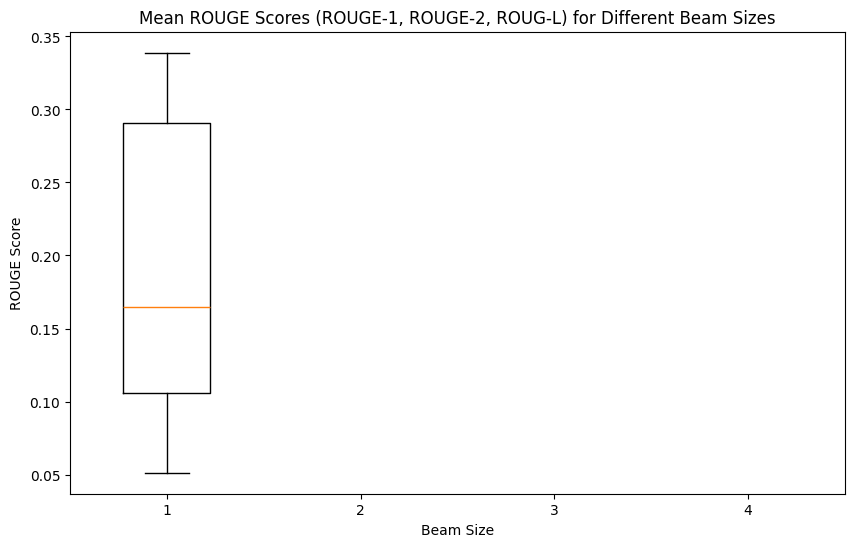

In [22]:
# create a boxplot to visualize different beam sizes
df = pd.read_csv("beam_sizes_results.csv")
plt.figure(figsize=(10, 6))
plt.boxplot(df.values, labels=df.columns)
plt.title("Mean ROUGE Scores (ROUGE-1, ROUGE-2, ROUG-L) for Different Beam Sizes")
plt.xlabel("Beam Size")
plt.ylabel("ROUGE Score")
plt.savefig("beam_sizes_results.png")
plt.show()


In [ ]:
# create a dataframe to store the results with different beam sizes
temperatures = [0.5,1,2,5]
temperatures_results = pd.DataFrame(columns=temperatures)
max_length = 10
num_samples = 10
beam_size = 1.0
no_repeat_ngram_size = 3
k = 5
p = 0.5
for temperature in temperatures:
    for i,sample in enumerate(dataset[:num_samples]):
        
        article = sample["article"]
        reference = sample["highlights"]
        generated = generate_summary_custom(article, strategy="top_p", max_length=max_length, temperature=temperature,k=k,p=p, beam_size=beam_size, no_repeat_ngram_size=no_repeat_ngram_size)
        # generated = "Students and faculty members marched Wednesday afternoon chanting"
        rouge1 = compute_rouge_n(reference, generated, n=1)["f1"]
        rouge2 = compute_rouge_n(reference, generated, n=2)["f1"]
        rougel = compute_rouge_l(reference, generated)["f1"]
        rouge_mean = (rouge1 + rouge2 + rougel) / 3
        temperatures_results.loc[i, temperature] = rouge_mean
        temperatures_results.to_csv("temperatures_results.csv", index=False) # save the results to a csv file
        

temperatures_results 


,0.5,1.0,2.0,5.0
0,0.124031,0.124031,0.0,0.0
1,0.279196,0.240474,0.064615,0.0
2,0.203819,0.203819,0.031746,0.0
3,0.052288,0.284615,0.076923,0.0
4,0.303855,0.153846,0.038462,0.0


/tmp/ipykernel_2621713/2895057818.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df.values, labels=df.columns)


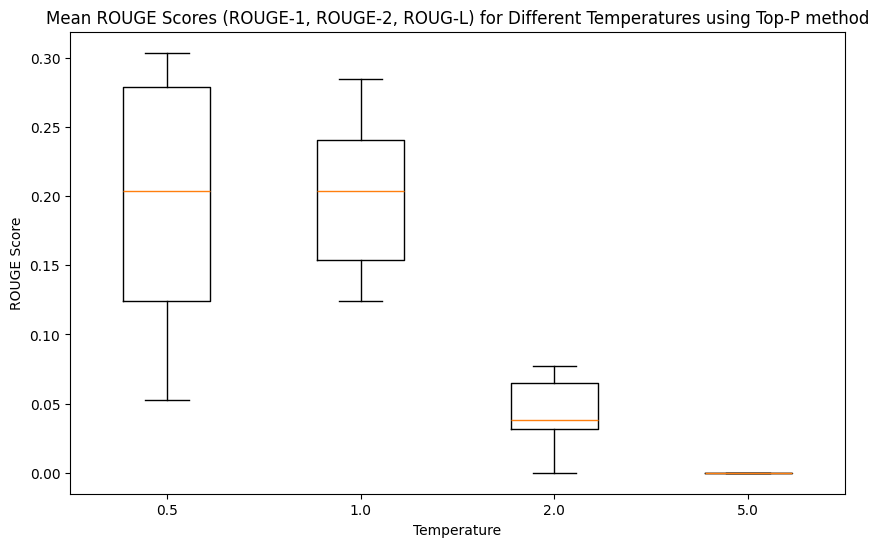

In [ ]:
# create a boxplot to visualize different beam sizes
df = pd.read_csv("temperatures_results.csv")
plt.figure(figsize=(10, 6))
plt.boxplot(df.values, labels=df.columns)
plt.title("Mean ROUGE Scores (ROUGE-1, ROUGE-2, ROUG-L) for Different Temperatures using Top-P method")
plt.xlabel("Temperature")
plt.ylabel("ROUGE Score")
plt.savefig("temperatures_results.png")
plt.show()
